# Power Patterns, thinkonward.com

This notebook is a submission to Onward's challenge [Power Patterns: Harnessing Electricity for Innovation](https://thinkonward.com/app/c/challenges/power-patterns).

It's proposal is simple: convert the 1-dimensional data of energy consumption over time into a 2-dimensional histogram representing likelihood of energy draw in a one-day period, and cluster profiles one the resulting surfaces.

The Notebook is in 3 parts:

1. load and process data
2. run through clustering algorithm
3. examine cluster properties

# 1. Load and Prepare Data

In [92]:
from utils import load_data

energy_data = load_data()

  0%|          | 0/1277 [00:00<?, ?it/s]

In [136]:
import numpy as np
from tqdm.notebook import tqdm
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from utils import make_heatmap, smooth_heatmap

N_BINS = 48

power_profiles = np.zeros((len(energy_data.columns), N_BINS, N_BINS))
lookup = {}
for i, col in tqdm(enumerate(energy_data.columns), total=len(energy_data.columns)):
    lookup[col] = i
    heatmap = make_heatmap(energy_data[col], N_BINS, '30min')
    smoothed = smooth_heatmap(heatmap)
    normalized = smoothed / smoothed.max().max()
    scaled = TimeSeriesScalerMeanVariance().fit_transform(normalized.values)
    power_profiles[i, :, :] = normalized.values

  0%|          | 0/1277 [00:00<?, ?it/s]

-7.37314540562379e-17 1.0


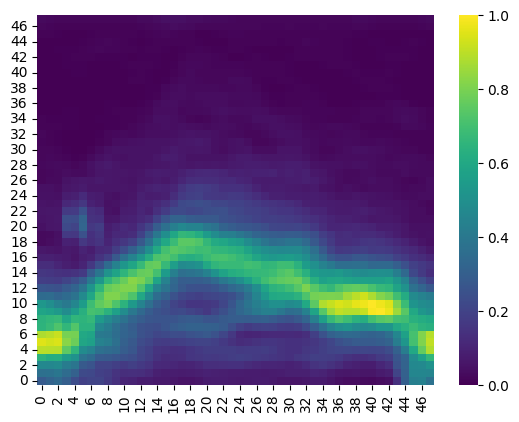

In [137]:
from utils import plot_heatmap


bu_id = '922'

profile = power_profiles[lookup[bu_id], :, :]
print(profile.min(), profile.max())

plot_heatmap(profile)

# 2. Cluster

In [139]:
from tslearn.clustering import KShape

ITER_CLUSTERS = 8

inertia = []
for i in tqdm(range(1, ITER_CLUSTERS+1)):
    ks = KShape(n_clusters=i, n_init=10)
    ks.fit(power_profiles)
    inertia.append(ks.inertia_)

  0%|          | 0/8 [00:00<?, ?it/s]

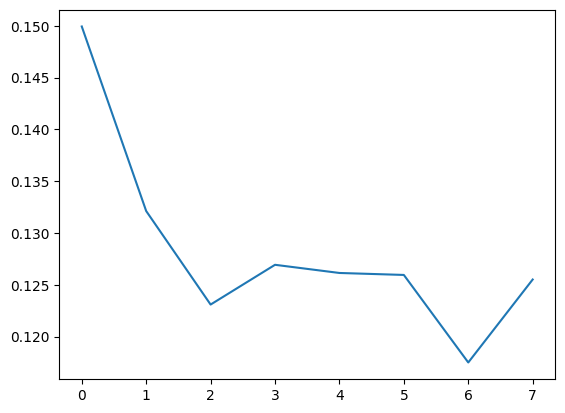

In [140]:
import matplotlib.pyplot as plt

plt.plot(inertia)

In [141]:
N_CLUSTERS = 3

ks = KShape(n_clusters=N_CLUSTERS, n_init=10)
ks.fit_predict(power_profiles)

array([2, 2, 0, ..., 2, 0, 1])

<Axes: >

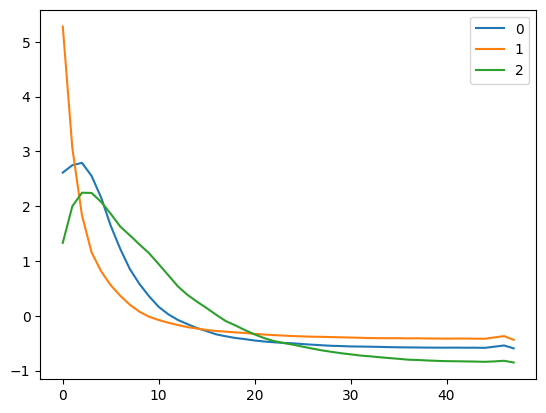

In [142]:
import pandas as pd

centers = pd.DataFrame(ks.cluster_centers_[:, :, 0].T)
centers.plot()

In [143]:
labels = pd.Series(ks.labels_)
labels.value_counts()

0    449
2    424
1    404
Name: count, dtype: int64

# 3. Examine Cluster Properties

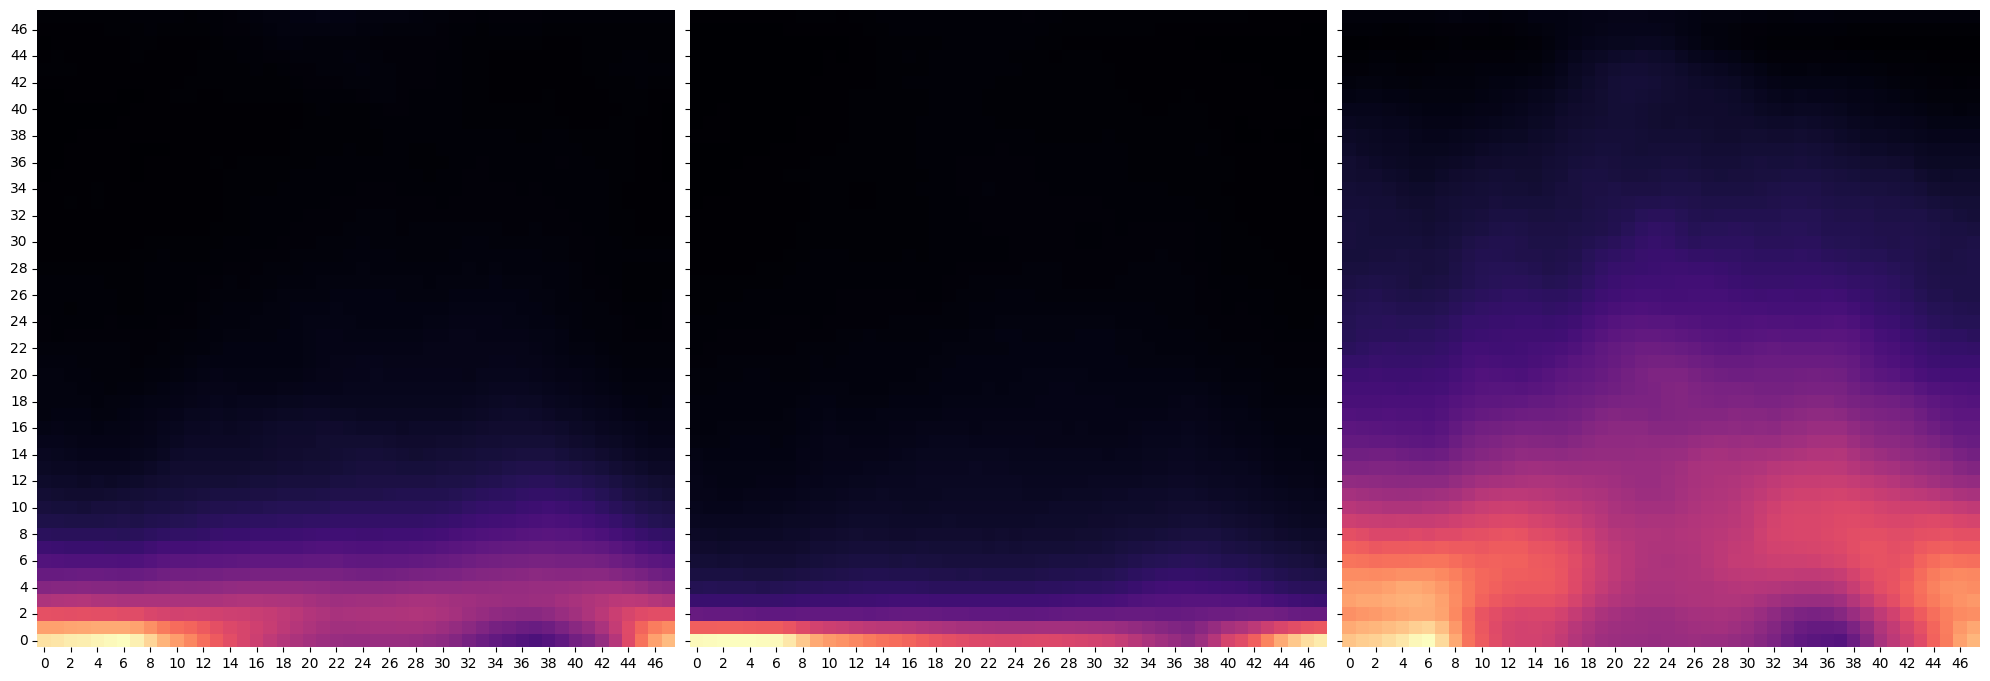

In [145]:
# What is the mean heatmap of each cluster?

fig, ax = plt.subplots(
    ncols=N_CLUSTERS,
    sharex=True, sharey=True,
    figsize=(20, 40),
    subplot_kw=dict(box_aspect=1),
    layout='tight',
)

for label in range(N_CLUSTERS):
    indexes = labels[labels == label].index
    mean_heatmap = np.mean(power_profiles[indexes, :, :], axis=0)
    sns.heatmap(mean_heatmap, cmap='magma', ax=ax[label], cbar=False)
    ax[label].invert_yaxis()

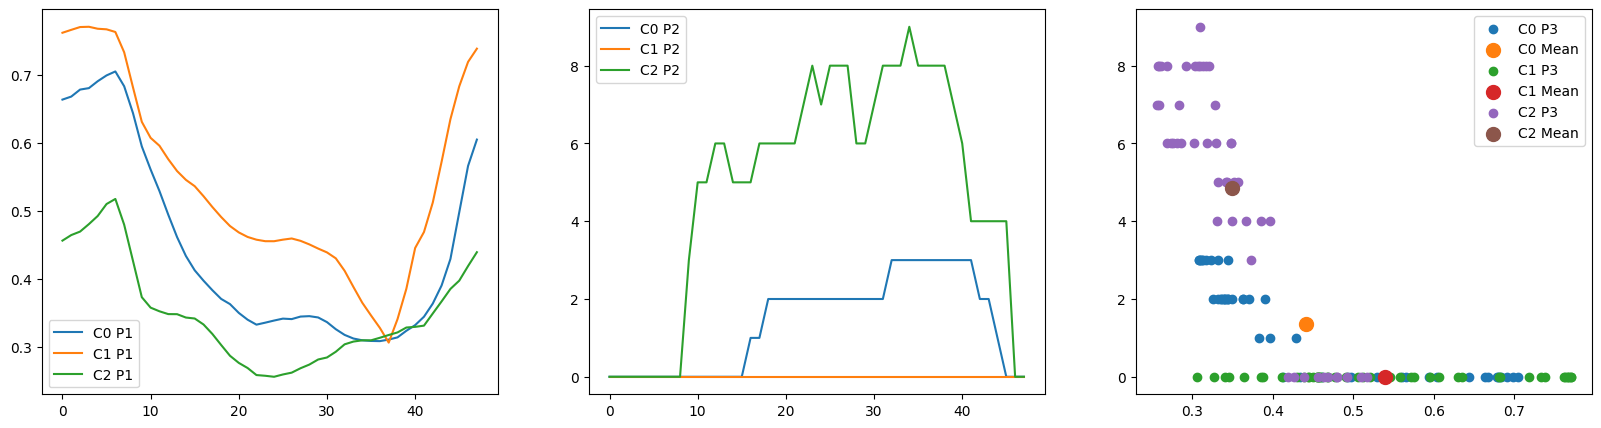

In [178]:
def plot_charts(random_sample=False):
    fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
    scores = {}

    for label in range(N_CLUSTERS):
        if random_sample:
            indexes = labels.sample(100).index
        else:
            indexes = labels[labels == label].index
        mean_heatmap = np.mean(power_profiles[indexes, :, :], axis=0)
        prop_1 = np.max(mean_heatmap, axis=0)
        ax[0].plot(prop_1, label=f'C{label} P1')
        prop_2 = np.argmax(mean_heatmap, axis=0)
        ax[1].plot(prop_2, label=f'C{label} P2')
        ax[2].scatter(prop_1, prop_2, label=f'C{label} P3')
        mean_prop_1 = np.mean(prop_1)
        mean_prop_2 = np.mean(prop_2)
        ax[2].scatter(mean_prop_1, mean_prop_2, label=f'C{label} Mean', s=100)
        if mean_prop_1 == 0:
            scores[label] = 1
        scores[label] = np.arctan(mean_prop_2/mean_prop_1)

    for axi in ax: axi.legend()
    return scores

scores = plot_charts()

In [168]:
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print('Predictability scores:')
for cluster, score in sorted_scores:
    print(f'    Cluster {cluster} -> {score:.2f}')

Predictability scores:
    Cluster 2 -> 1.50
    Cluster 0 -> 1.26
    Cluster 1 -> 0.00


{0: 0.7914264142221195, 1: 0.6878270583468779, 2: 0.7736363809628818}

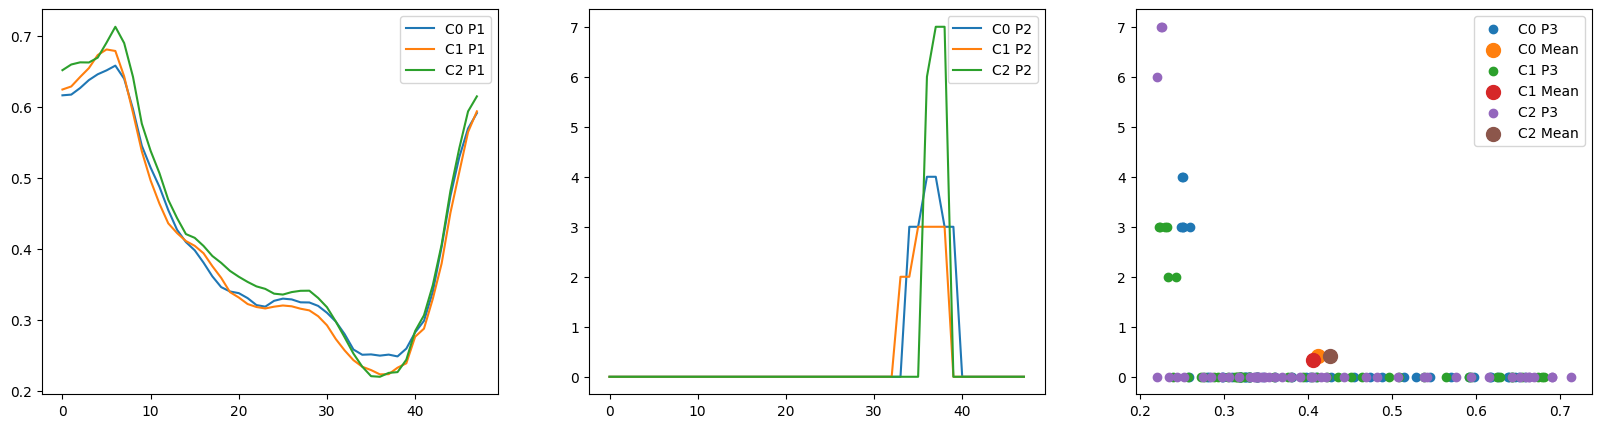

In [179]:
plot_charts(random_sample=True)

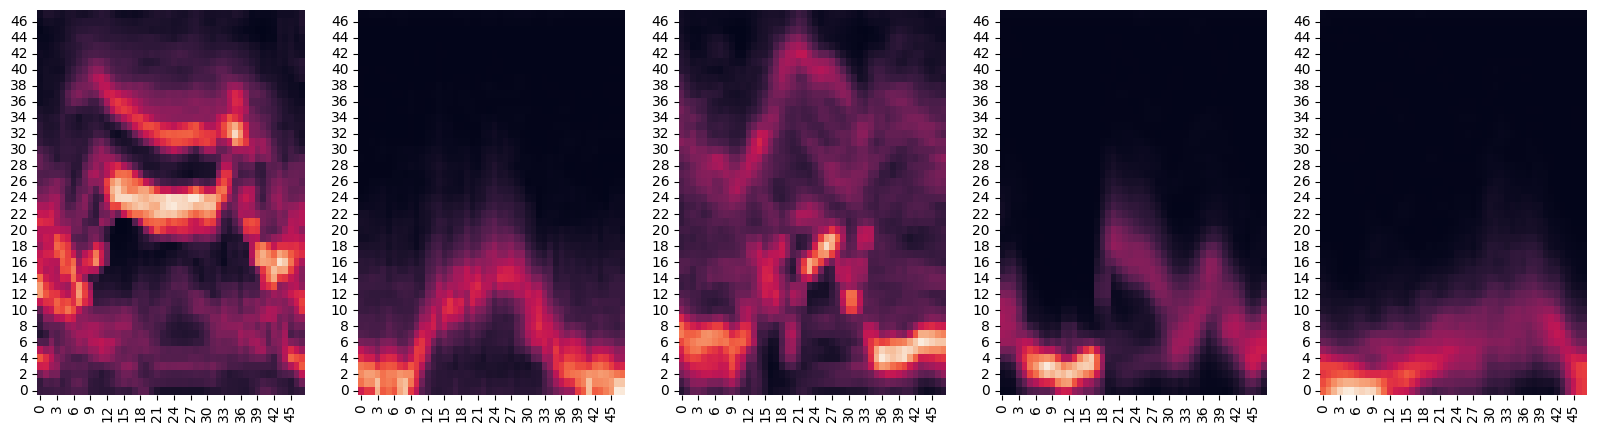

In [170]:
# How predictable is each cluster?

least_predictable = sorted_scores[0][0]

SAMPLE = 5
fig, ax = plt.subplots(ncols=SAMPLE, figsize=(20, 5))

indexes = labels[labels == least_predictable].sample(SAMPLE).index
for i, index in enumerate(indexes):
    sns.heatmap(power_profiles[index, :, :], ax=ax[i], cbar=False)
    ax[i].invert_yaxis()


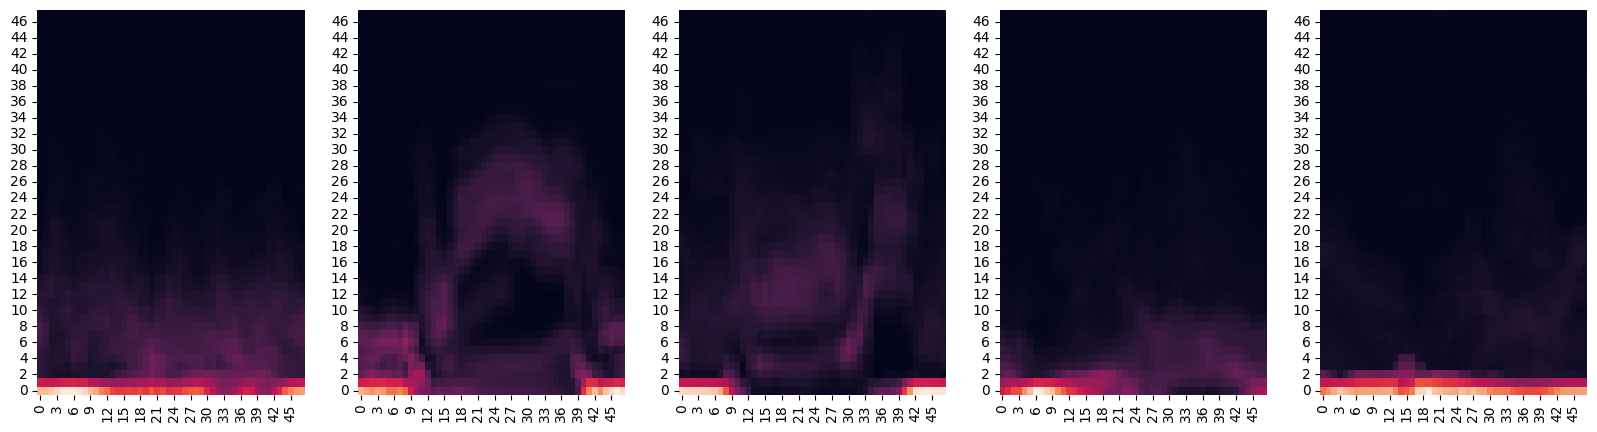

In [171]:
most_predictable = sorted_scores[-1][0]

fig, ax = plt.subplots(ncols=SAMPLE, figsize=(20, 5))

indexes = labels[labels == most_predictable].sample(SAMPLE).index
for i, index in enumerate(indexes):
    sns.heatmap(power_profiles[index, :, :], ax=ax[i], cbar=False)
    ax[i].invert_yaxis()

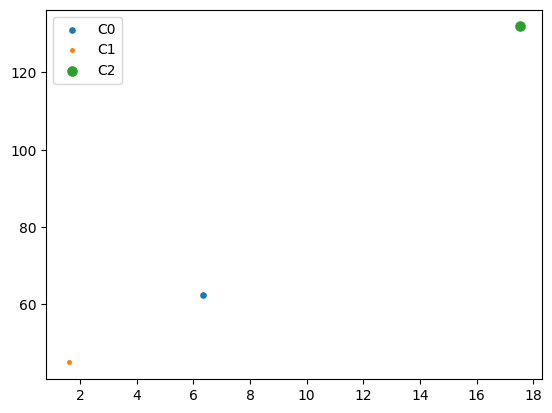

In [173]:
for label in range(N_CLUSTERS):
    indexes = labels[labels == label].index
    tot_energy_per_bu = energy_data.iloc[:, indexes].min(axis=0)
    avg_energy = tot_energy_per_bu.mean()

    peak_power = energy_data.iloc[:, indexes].max(axis=0)
    avg_peak_power = peak_power.mean()

    min_power = energy_data.iloc[:, indexes].mean(axis=0)
    avg_min_power = min_power.mean()
    plt.scatter(avg_energy, avg_peak_power, avg_min_power, label=f'C{label}')

plt.legend();

# Conclusion


- small change to otherwise straightforward approach
- using heatmap allows to assign meaning to clusters in a more human-friendly way
- what next
    - compare to average energy profiles grouping

